## Analisis Data Segmentasi Nasabah Bank

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

### Exploratory Data Analysis (EDA)

#### Inspeksi Awal Data

In [2]:
df = pd.read_csv('bank_transactions.csv')

df.info()
print(df.describe())
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB
       CustAccountBalance  TransactionTime  TransactionAmount (INR)
count        1.046198e+06     1.048567e+06             1.048567e+06
mean         1.154035e+05     1.570875e+05             1.574335e+03
std  

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.00
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.00
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.00
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.00
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.50
5,T6,C1536588,8/10/72,F,ITANAGAR,53609.20,2/8/16,173940,676.00
6,T7,C7126560,26/1/92,F,MUMBAI,973.46,2/8/16,173806,566.00
7,T8,C1220223,27/1/82,M,MUMBAI,95075.54,2/8/16,170537,148.00
8,T9,C8536061,19/4/88,F,GURGAON,14906.96,2/8/16,192825,833.00
9,T10,C6638934,22/6/84,M,MUMBAI,4279.22,2/8/16,192446,289.11


 #### Penanganan Missing Values dan Cek Outlier

In [53]:

print("Sebelum Penanganan Missing Values: ")
print(df.isnull().sum())

print("Setelah Penanganan Missing Values: ")
df = df.dropna()
print(df.isnull().sum())

# import seaborn as sns
# sns.boxplot(df)

Sebelum Penanganan Missing Values: 
TransactionID                 0
CustomerID                    0
CustomerDOB                3397
CustGender                 1100
CustLocation                151
CustAccountBalance         2369
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
dtype: int64
Setelah Penanganan Missing Values: 
TransactionID              0
CustomerID                 0
CustomerDOB                0
CustGender                 0
CustLocation               0
CustAccountBalance         0
TransactionDate            0
TransactionTime            0
TransactionAmount (INR)    0
dtype: int64


### Analisis Univariat

<Figure size 1200x500 with 0 Axes>

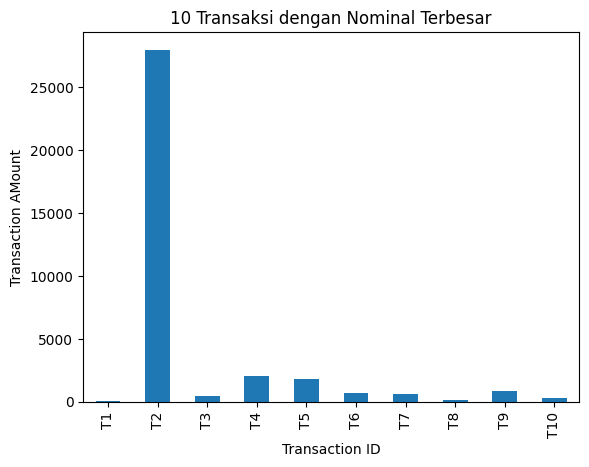

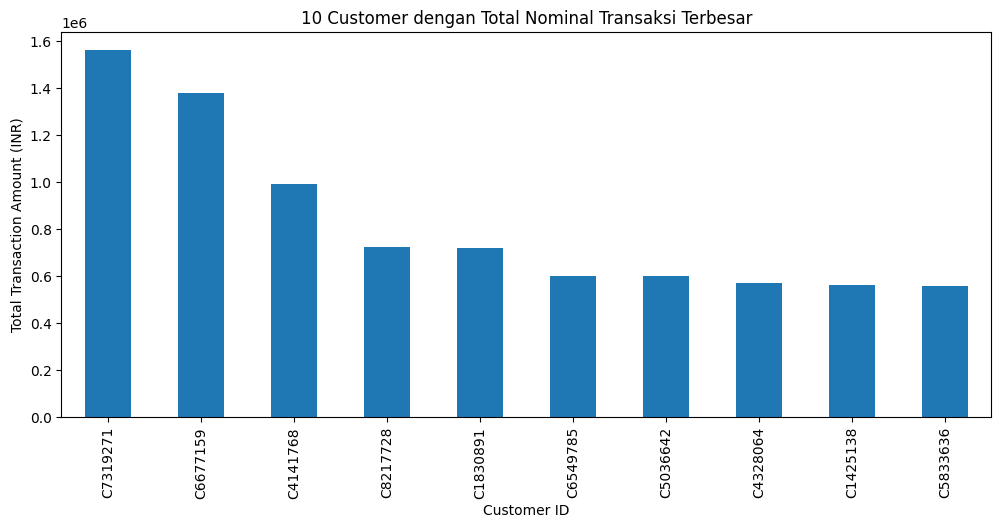

In [54]:
plt.figure(figsize=(12,5))
df.head(10).plot(
    x="TransactionID",
    y="TransactionAmount (INR)",
    kind='bar',
    legend=False
)
plt.title('10 Transaksi dengan Nominal Terbesar')
plt.xlabel('Transaction ID')
plt.ylabel('Transaction AMount')
plt.show()

customer_sum = df.groupby('CustomerID')['TransactionAmount (INR)'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12,5))
customer_sum.plot(kind='bar')

plt.title('10 Customer dengan Total Nominal Transaksi Terbesar')
plt.xlabel('Customer ID')
plt.ylabel('Total Transaction Amount (INR)')
plt.show()

### Data Processing

In [55]:
df_agg = df.groupby('CustomerID').agg(
    Jumlah_Transaksi=('TransactionID', 'count'),
    Total_Amount=('TransactionAmount (INR)', 'sum'),
    Avg_Amount=('TransactionAmount (INR)', 'mean'),
    Max_Amount=('TransactionAmount (INR)', 'max'),
    Mean_AccountBalance=('CustAccountBalance', 'mean'),
    CustGender=('CustGender', 'first'),
    CustLocation=('CustLocation', 'first'),
    CustomerDOB=('CustomerDOB', 'first')
).reset_index()


#### Standarisasi Fitur Numerik

In [56]:
# Konversi Date of Birth (DOB) ke Umur
df_agg['CustomerDOB'] = pd.to_datetime(df_agg['CustomerDOB'], format='%d/%m/%y', errors='coerce')
# print(df['CustomerDOB'].dt.year.value_counts().sort_index())
df_agg.loc[df_agg['CustomerDOB'].dt.year > 2025, 'CustomerDOB'] = df_agg['CustomerDOB'] - pd.DateOffset(years=100)
df_agg['CustomerDOB'].head(10)
today = pd.Timestamp.now()
df_agg['Umur'] = (today - df_agg['CustomerDOB']).dt.days // 365
df_agg = df_agg.dropna()
print(df_agg['Umur'].isna().sum())
df_agg['Umur'] = df_agg['Umur'].astype(int)
print(df_agg[['CustomerID','Umur']].head(10))
# df_agg.drop(df_agg['CustomerDOB'])

# Konversi Gender Male dan Female ke 0 dan 1
df_agg['CustGender'] = df_agg['CustGender'].map({'M': 1, 'F': 0})
df_agg.head(10)


0
  CustomerID  Umur
0   C1010011    33
1   C1010012    31
2   C1010014    33
3   C1010018    35
4   C1010024    60
5   C1010028    37
6   C1010031    41
7   C1010035    33
8   C1010036    29
9   C1010037    44


,CustomerID,Jumlah_Transaksi,Total_Amount,Avg_Amount,Max_Amount,Mean_AccountBalance,CustGender,CustLocation,CustomerDOB,Umur
0,C1010011,2,5106.0,2553.0,4750.0,76340.635,0,NOIDA,1992-08-19,33
1,C1010012,1,1499.0,1499.0,1499.0,24204.490,1,MUMBAI,1994-07-28,31
2,C1010014,2,1455.0,727.5,1205.0,100112.950,0,MUMBAI,1992-06-04,33
3,C1010018,1,30.0,30.0,30.0,496.180,0,CHAMPARAN,1990-05-29,35
4,C1010024,1,5000.0,5000.0,5000.0,87058.650,1,KOLKATA,1965-06-21,60
5,C1010028,1,557.0,557.0,557.0,296828.370,0,DELHI,1988-08-25,37
6,C1010031,2,1864.0,932.0,1460.0,5200.155,1,VAPI,1984-07-21,41
7,C1010035,2,750.0,375.0,700.0,192648.755,1,MUMBAI,1992-03-02,33
8,C1010036,1,208.0,208.0,208.0,355430.170,1,GURGAON,1996-02-26,29
9,C1010037,1,19680.0,19680.0,19680.0,95859.170,1,BANGALORE,1981-09-13,44


#### Scaling Data

In [57]:

# Scaling Data
num_cols = ['Jumlah_Transaksi','Total_Amount','Avg_Amount',
            'Max_Amount','Mean_AccountBalance','CustGender',
            'Umur']

scaler = StandardScaler()
df_agg[num_cols] = scaler.fit_transform(df_agg[num_cols])
df_agg.head(10)


,CustomerID,Jumlah_Transaksi,Total_Amount,Avg_Amount,Max_Amount,Mean_AccountBalance,CustGender,CustLocation,CustomerDOB,Umur
0,C1010011,1.817447,0.495424,0.179891,0.458731,-0.038888,-1.614969,NOIDA,1992-08-19,-0.780142
1,C1010012,-0.410966,-0.035711,0.005863,-0.024927,-0.106624,0.619207,MUMBAI,1994-07-28,-1.008570
2,C1010014,1.817447,-0.042190,-0.121520,-0.068666,-0.008003,-1.614969,MUMBAI,1992-06-04,-0.780142
3,C1010018,-0.410966,-0.252023,-0.236685,-0.243473,-0.137426,-1.614969,CHAMPARAN,1990-05-29,-0.551714
4,C1010024,-0.410966,0.479816,0.583919,0.495924,-0.024963,0.619207,KOLKATA,1965-06-21,2.303641
5,C1010028,-0.410966,-0.174422,-0.149672,-0.165070,0.247571,-1.614969,DELHI,1988-08-25,-0.323285
6,C1010031,1.817447,0.018036,-0.087755,-0.030729,-0.131315,0.619207,VAPI,1984-07-21,0.133571
7,C1010035,1.817447,-0.146002,-0.179722,-0.143796,0.112220,0.619207,MUMBAI,1992-03-02,-0.780142
8,C1010036,-0.410966,-0.225812,-0.207296,-0.216992,0.323707,0.619207,GURGAON,1996-02-26,-1.236999
9,C1010037,-0.410966,2.641464,3.007757,2.679897,-0.013530,0.619207,BANGALORE,1981-09-13,0.476214


#### Encoding Data Column 'CustLocation'

In [58]:
# Encoding kolom kategorical dari Customer Location
top_locations = df_agg['CustLocation'].value_counts().head(50).index
df_agg['CustLocation_reduced'] = df_agg['CustLocation'].apply(lambda x: x if x in top_locations else 'Other')

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
encoded_sparse = encoder.fit_transform(df_agg[['CustLocation_reduced']])
encoded_df = pd.DataFrame.sparse.from_spmatrix(encoded_sparse, columns=encoder.get_feature_names_out(['CustLocation_reduced']))
df_agg = pd.concat([df_agg.drop(columns=['CustLocation_reduced']).reset_index(drop=True), encoded_df], axis=1)

df_agg.info()
df_agg.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831803 entries, 0 to 831802
Data columns (total 61 columns):
 #   Column                              Non-Null Count   Dtype             
---  ------                              --------------   -----             
 0   CustomerID                          831803 non-null  object            
 1   Jumlah_Transaksi                    831803 non-null  float64           
 2   Total_Amount                        831803 non-null  float64           
 3   Avg_Amount                          831803 non-null  float64           
 4   Max_Amount                          831803 non-null  float64           
 5   Mean_AccountBalance                 831803 non-null  float64           
 6   CustGender                          831803 non-null  float64           
 7   CustLocation                        831803 non-null  object            
 8   CustomerDOB                         831803 non-null  datetime64[ns]    
 9   Umur                                8

C:\Users\ASUS\AppData\Local\Temp\ipykernel_27868\2163218816.py:10: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df_agg.info()


,CustomerID,Jumlah_Transaksi,Total_Amount,Avg_Amount,Max_Amount,Mean_AccountBalance,CustGender,CustLocation,CustomerDOB,Umur,...,CustLocation_reduced_PUNE,CustLocation_reduced_RANCHI,CustLocation_reduced_RANGA REDDY,CustLocation_reduced_REWARI,CustLocation_reduced_SECUNDERABAD,CustLocation_reduced_SURAT,CustLocation_reduced_THANE,CustLocation_reduced_UDAIPUR,CustLocation_reduced_VADODARA,CustLocation_reduced_VISAKHAPATNAM
0,C1010011,1.817447,0.495424,0.179891,0.458731,-0.038888,-1.614969,NOIDA,1992-08-19,-0.780142,...,0,0,0,0,0,0,0,0,0,0
1,C1010012,-0.410966,-0.035711,0.005863,-0.024927,-0.106624,0.619207,MUMBAI,1994-07-28,-1.008570,...,0,0,0,0,0,0,0,0,0,0
2,C1010014,1.817447,-0.042190,-0.121520,-0.068666,-0.008003,-1.614969,MUMBAI,1992-06-04,-0.780142,...,0,0,0,0,0,0,0,0,0,0
3,C1010018,-0.410966,-0.252023,-0.236685,-0.243473,-0.137426,-1.614969,CHAMPARAN,1990-05-29,-0.551714,...,0,0,0,0,0,0,0,0,0,0
4,C1010024,-0.410966,0.479816,0.583919,0.495924,-0.024963,0.619207,KOLKATA,1965-06-21,2.303641,...,0,0,0,0,0,0,0,0,0,0
5,C1010028,-0.410966,-0.174422,-0.149672,-0.165070,0.247571,-1.614969,DELHI,1988-08-25,-0.323285,...,0,0,0,0,0,0,0,0,0,0
6,C1010031,1.817447,0.018036,-0.087755,-0.030729,-0.131315,0.619207,VAPI,1984-07-21,0.133571,...,0,0,0,0,0,0,0,0,0,0
7,C1010035,1.817447,-0.146002,-0.179722,-0.143796,0.112220,0.619207,MUMBAI,1992-03-02,-0.780142,...,0,0,0,0,0,0,0,0,0,0
8,C1010036,-0.410966,-0.225812,-0.207296,-0.216992,0.323707,0.619207,GURGAON,1996-02-26,-1.236999,...,0,0,0,0,0,0,0,0,0,0
9,C1010037,-0.410966,2.641464,3.007757,2.679897,-0.013530,0.619207,BANGALORE,1981-09-13,0.476214,...,0,0,0,0,0,0,0,0,0,0


### KMeans Algorithm

In [ ]:
df_num = df_agg.select_dtypes(include='number')
df_num.head(10)

pca = PCA(n_components=5, random_state=42)
df_reduced = pca.fit_transform(df_num)

wcss = []
scores = []

for i in range (2,11):
  k_means = KMeans(n_clusters=i, random_state=42)
  k_means.fit(df_reduced)

  wcss.append(k_means.inertia_)
  scores.append(silhouette_score(df_reduced, k_means.labels_))

  print(f"WCSS Scores for cluster {i}: {k_means.inertia_}")
  print(f"Silhoutte Scores for cluster {i}: {silhouette_score(df_reduced, k_means.labels_)}")

c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:919: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


#### WCSS dan Silhoutte

In [ ]:
k = range(2,11)

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('WCSS', color=color)
ax1.plot(k, wcss, marker='o', color=color, label="WCSS")
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc="upper right")

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Silhouette Score', color=color)
ax2.plot(k, scores, marker='s', color=color, label="Silhouette Score")
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc="upper center")

plt.title("Perbanddingan WCSS dan Silhoutte")
plt.show()